# Univariate LSTM Time Series Prediction

In [2]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 15, 6

# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep-learing
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras import backend as K


from python_code.data_preparation import create_tensors

Using TensorFlow backend.


## Data Description

A detailed data description can be found on Kaggle: [Kaggle: Smart Meters in London](https://www.kaggle.com/jeanmidev/smart-meters-in-london).

### Parameters

#### Data Parameters

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. 

- Number of series: 4961
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)
- End test range: 2014-01-27 23:00:00 (90 days)
- One days ahead prediction

In [15]:
data_path = 'prepared_data/london_smart_meter/'
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')

### Load Data

The Kaggle dataset was cleaned and prepared in R (`00_load_smart_meter_data.R`). The smart meter series are saved in the long format. 

In [16]:
df = pd.read_csv(data_path + file,
                 parse_dates={'date' : ['date_time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col=['date'])

`write_csv` from the `readr` package writes date time values in UCT format. Therefore, we have set the correct zone.

In [17]:
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')
df.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,id,energy
date,,,,,,,,,,
2013-10-30 00:00:00+01:00,14.31,244,6.86,4.61,1017.98,4.55,3.29,0.86,MAC000002,0.457
2013-10-30 01:00:00+01:00,14.31,238,6.10,4.09,1018.38,3.86,2.95,0.87,MAC000002,0.414
2013-10-30 02:00:00+01:00,13.45,247,5.94,4.17,1018.89,3.54,3.14,0.88,MAC000002,0.408
2013-10-30 03:00:00+01:00,13.23,249,5.54,3.92,1019.25,3.13,3.02,0.89,MAC000002,0.352
2013-10-30 04:00:00+01:00,14.31,242,5.06,3.28,1019.57,2.78,2.74,0.88,MAC000002,0.250


Let us check some characteristics of the series.

In [18]:
uniqueIDs = df['id'].unique()
len(uniqueIDs)

1

In [19]:
uniqueIDs

array(['MAC000002'], dtype=object)

In [20]:
df.groupby('id').count().describe()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,energy
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0
25%,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0
50%,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0
75%,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0
max,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0


In [21]:
2904 / 24

121.0

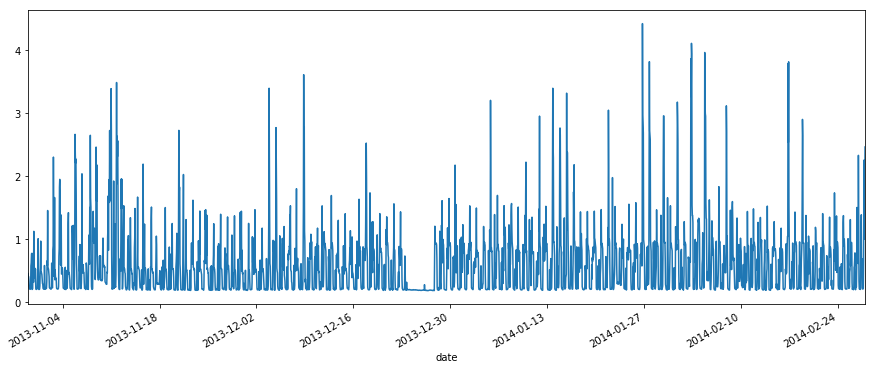

In [22]:
df[df['id'] == 'MAC000002']['energy'].plot()

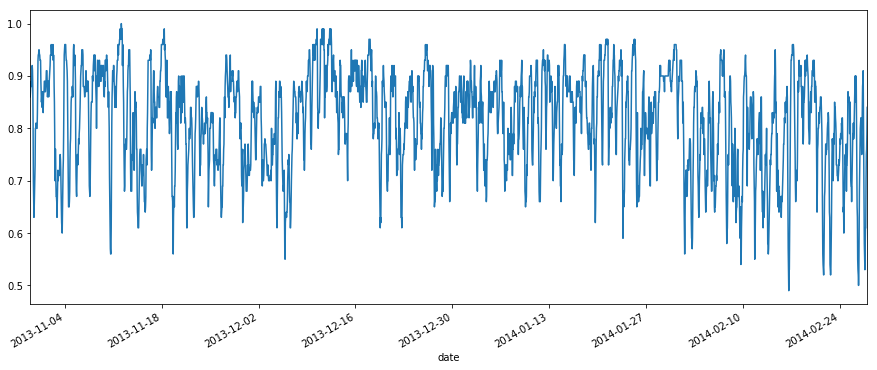

In [26]:
df[df['id'] == 'MAC000002']['humidity'].plot()

Now, splite train and test.

In [27]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

## Prepare Data for LSTM

Let us start with a single series. In the next steps we have to generate the 3 dimensional arrays ([samples, n_in, n_features]) that we need for the LSTM. But before we do this, we have to normalize data. 

In [28]:
df_train = df_train[df_train['id'] == 'MAC000002']
df_test = df_test[df_test['id'] == 'MAC000002']

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])

In [30]:
df_train[[h_params['column_value']]].describe()

,energy
count,2160.000000
mean,0.090101
std,0.118516
min,0.000000
25%,0.005903
50%,0.052302
75%,0.140024
max,1.000000


In [31]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [32]:
train_X.shape

(89, 24, 9)

### Define & Train LSTM Network

Let us try a simple 3 layer LSTM network.  

In [33]:
def keras_model(rate):
    model = Sequential()
    model.add(Dropout(rate, input_shape=(train_X.shape[1], train_X.shape[2])))
    lstm = LSTM(256, recurrent_dropout=0.3)
    model.add(lstm)
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dropout(rate))
    model.add(Dense(128))
    model.add(Dense(h_params['n_out']))
    return model

In [61]:
model = keras_model(0.2)
model.compile(loss='mae', optimizer = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_split = .1, verbose=2, shuffle=True)

Train on 80 samples, validate on 9 samples
Epoch 1/50
 - 3s - loss: 0.5176 - val_loss: 0.2149
Epoch 2/50
 - 3s - loss: 0.3524 - val_loss: 0.1841
Epoch 3/50
 - 3s - loss: 0.2846 - val_loss: 0.1395
Epoch 4/50
 - 3s - loss: 0.2402 - val_loss: 0.1048
Epoch 5/50
 - 3s - loss: 0.1969 - val_loss: 0.1107
Epoch 6/50
 - 3s - loss: 0.1774 - val_loss: 0.0941
Epoch 7/50
 - 3s - loss: 0.1625 - val_loss: 0.0862
Epoch 8/50
 - 3s - loss: 0.1468 - val_loss: 0.0830
Epoch 9/50
 - 3s - loss: 0.1335 - val_loss: 0.0758
Epoch 10/50
 - 3s - loss: 0.1221 - val_loss: 0.0808
Epoch 11/50
 - 3s - loss: 0.1155 - val_loss: 0.0732
Epoch 12/50
 - 2s - loss: 0.1120 - val_loss: 0.0741
Epoch 13/50
 - 3s - loss: 0.1057 - val_loss: 0.0803
Epoch 14/50
 - 3s - loss: 0.1014 - val_loss: 0.0827
Epoch 15/50
 - 3s - loss: 0.0940 - val_loss: 0.0675
Epoch 16/50
 - 3s - loss: 0.0938 - val_loss: 0.0773
Epoch 17/50
 - 3s - loss: 0.0877 - val_loss: 0.0674
Epoch 18/50
 - 3s - loss: 0.0849 - val_loss: 0.0709
Epoch 19/50
 - 3s - loss: 0.08

Summarise the training and validation loss

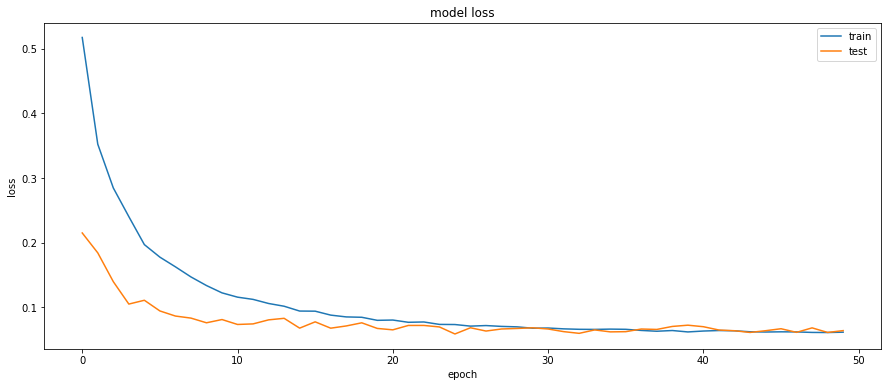

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Perform prediction

In [63]:
test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [64]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

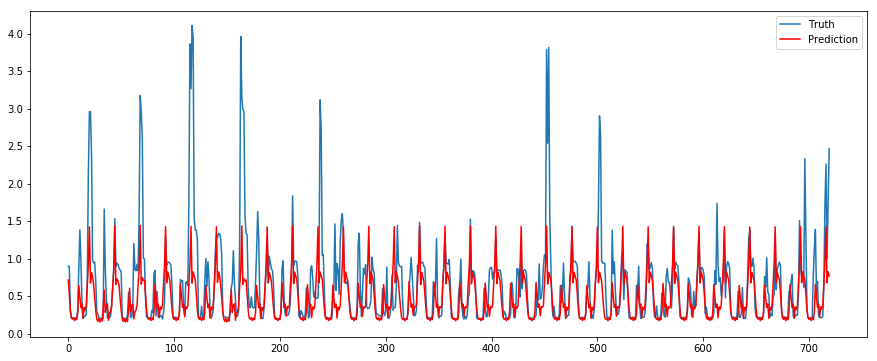

In [65]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [66]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 34.26 SMAPE: 18.61


This can be done better. But let us next try to calculate confidence bands.

## Confidence Bands

In [67]:
def predict_with_uncertainty2(model, test_X, n_iter=100):
    f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1, 24,))
    for iter in range(n_iter):
        all_pred[iter] = f([test_X, 1])
    ts_std = all_pred.std(axis = 0)
    avg_pred = all_pred.mean(axis=0)
    return all_pred, avg_pred, ts_std

In [68]:
test_X[i].shape[1]

9

Let us predict the first 10 days with confidence bands.

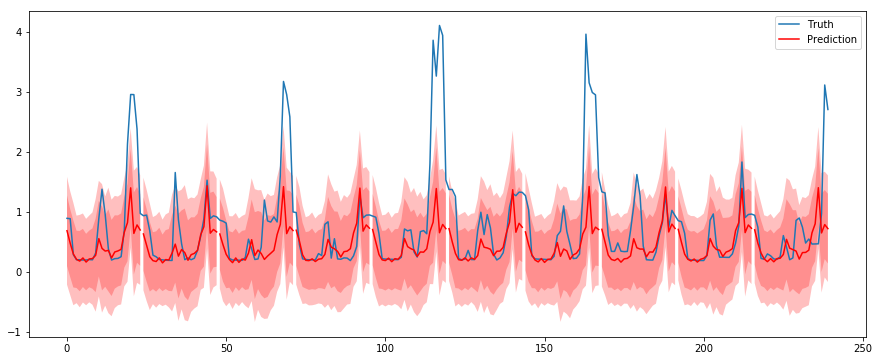

In [69]:
n = 10
plt.plot(y[:(n * 24)])
# n = len(test_X)
for i in range(0, n):
    _, avg_pred, ts_std = predict_with_uncertainty2(model, test_X[i].reshape(1, 24, test_X[i].shape[1]), 100)
    yHat = scaler.inverse_transform(avg_pred).reshape(avg_pred.shape[0] * avg_pred.shape[1])
    YHat_SD = scaler.inverse_transform(ts_std).reshape(ts_std.shape[0] * ts_std.shape[1])
    y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])
    plt.plot(range(i * 24, (i + 1) * 24), yHat, color='red')
    # plots the uncertainty to the degree of half a standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 1.96 * YHat_SD, 
                     yHat - 1.96 * YHat_SD, 
                     facecolor='red', alpha=0.25)

    # plots the uncertainty to the degree of a full standard deviation
    plt.fill_between(range(i * 24, (i + 1) * 24),
                     yHat + 3 * YHat_SD, 
                     yHat - 3 * YHat_SD, 
                     facecolor='red', alpha=0.25)
    plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

# Add Time Features

In [70]:
df_train['weekday'] = df_train.index.weekday / 6
df_train['hour'] = df_train.index.hour / 23
df_test['weekday'] = df_test.index.weekday / 6
df_test['hour'] = df_test.index.hour / 23

In [71]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [72]:
model = keras_model(0.2)
model.compile(loss='mae', optimizer = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_split = .1, verbose=2, shuffle=True)

Train on 80 samples, validate on 9 samples
Epoch 1/25
 - 3s - loss: 0.5084 - val_loss: 0.1482
Epoch 2/25
 - 3s - loss: 0.3417 - val_loss: 0.1550
Epoch 3/25
 - 3s - loss: 0.2660 - val_loss: 0.1412
Epoch 4/25
 - 3s - loss: 0.2217 - val_loss: 0.1330
Epoch 5/25
 - 3s - loss: 0.1945 - val_loss: 0.0991
Epoch 6/25
 - 3s - loss: 0.1739 - val_loss: 0.1001
Epoch 7/25
 - 3s - loss: 0.1571 - val_loss: 0.0955
Epoch 8/25
 - 3s - loss: 0.1412 - val_loss: 0.0780
Epoch 9/25
 - 3s - loss: 0.1272 - val_loss: 0.0804
Epoch 10/25
 - 3s - loss: 0.1215 - val_loss: 0.0708
Epoch 11/25
 - 3s - loss: 0.1096 - val_loss: 0.0855
Epoch 12/25
 - 3s - loss: 0.1049 - val_loss: 0.0792
Epoch 13/25
 - 3s - loss: 0.1016 - val_loss: 0.0694
Epoch 14/25
 - 3s - loss: 0.0951 - val_loss: 0.0789
Epoch 15/25
 - 3s - loss: 0.0939 - val_loss: 0.0762
Epoch 16/25
 - 3s - loss: 0.0885 - val_loss: 0.0658
Epoch 17/25
 - 3s - loss: 0.0851 - val_loss: 0.0689
Epoch 18/25
 - 3s - loss: 0.0836 - val_loss: 0.0622
Epoch 19/25
 - 3s - loss: 0.08

In [214]:
test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [215]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

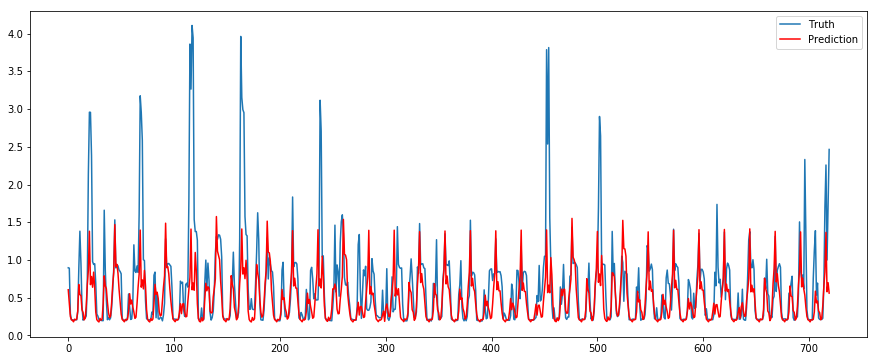

In [216]:
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [217]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 32.16 SMAPE: 17.75
